#Part 2. Binary Matrix of abnormal results, PCA & t-SNE, Random Forest - David Dangond

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/Spoke/"

Mounted at /content/drive


In [ ]:
cleaned = pd.read_csv(filepath + 'cleaned_ehr.csv')
cleaned = cleaned.drop('age_range', axis = 1)
cleaned

<ipython-input-2-3893a365d64d>:1: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned = pd.read_csv(filepath + 'cleaned_ehr.csv')


,Unnamed: 0,OMOPid,manufacturer,unit,range_low,range_high,gender,ethnicity,race,age,LOINCid
0,1107112,3006467,LAB3381,umol/l,31.26,84.11,Female,Not Hispanic or Latino,White or Caucasian,19,30195-2
1,5202898,3006467,LC4764,umol/l,35.60,101.60,Female,Not Hispanic or Latino,Black or African American,38,30195-2
2,6504574,3006467,LAB3381,umol/l,32.10,71.90,Female,Not Hispanic or Latino,White or Caucasian,14,30195-2
3,8245085,3006467,LAB3381,umol/l,31.26,84.11,Male,Not Hispanic or Latino,White or Caucasian,58,30195-2
4,13622773,3006467,LAB3381,umol/l,31.26,84.11,Male,Not Hispanic or Latino,Asian,68,30195-2
...,...,...,...,...,...,...,...,...,...,...,...
5840907,14239825,3016699,LAB3020,mg/dl,70.00,139.00,Female,Not Hispanic or Latino,Unknown,41,1504-0
5840908,14242860,3016699,LAB3020,mg/dl,70.00,139.00,Female,Not Hispanic or Latino,White or Caucasian,20,1504-0
5840909,14243816,3016699,LAB3020,mg/dl,70.00,139.00,Female,Not Hispanic or Latino,Asian,33,1504-0
5840910,14243911,3016699,LAB3020,mg/dl,70.00,139.00,Female,Not Hispanic or Latino,Native Hawaiian or Other Pacific Islander,44,1504-0


In [ ]:
# change any to a unique int to facilitate demographic matching
cleaned['age'] = cleaned['age'].replace('any', 1000)

def ageDec(df):
    df['age'] = [5*round(int(age)/5) for age in df['age']]
    df = df.rename(columns = {"age":"apx_half_decade"})
ageDec(cleaned)

In [ ]:
cleaned = cleaned.rename(columns = {"age":"apx_half_decade"})

In [ ]:
cleaned = cleaned.drop_duplicates(subset = ["OMOPid", "range_low", "range_high", "gender", "ethnicity", "race", "apx_half_decade"])



In [ ]:
res = pd.read_table(filepath + 'matched_lab_df.tsv')
dem = pd.read_table(filepath + 'cohort_df.tsv')

<ipython-input-3-938e837e0d45>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_table(filepath + 'matched_lab_df.tsv')


In [ ]:
results

,cohort_id,OMOPid,omop_date,value_as_number,value_as_concept_id,unit_concept_id,unit_source_value,measurement_source_value,value_source_value
0,0,3013721,2009-09-03,18.0,NaN,8645.0,U/L,1526000,18
1,0,3019550,2009-02-10,138.0,NaN,8753.0,MMOL/L,1534098,138
2,0,3035995,2009-09-03,59.0,NaN,8645.0,U/L,1525848,59
3,0,3044491,2009-02-10,122.0,NaN,8840.0,MG/DL,676,122
4,0,3022192,2009-02-10,50.0,NaN,8840.0,MG/DL,1552156,50
...,...,...,...,...,...,...,...,...,...
1462617,86434,3012888,2016-07-25,92.0,NaN,NaN,NaN,5,153/92
1462618,86434,3012888,2003-12-06,85.0,NaN,NaN,NaN,5,149/85
1462619,86434,3012888,2021-06-11,86.0,NaN,NaN,NaN,5,141/86
1462620,86434,3012888,2021-06-11,100.0,NaN,NaN,NaN,5,161/100


In [ ]:
dem

,cohort_id,gender_source_value,ethnicity_source_value,race_source_value,birthday,age,apx_half_decade,is_ms
0,0,Female,Not Hispanic or Latino,Black or African American,1960-03-07,62,60,False
1,1,Male,Unknown,White or Caucasian,1969-07-27,53,50,False
2,2,Female,Not Hispanic or Latino,Unknown,1976-10-10,46,45,False
3,3,Female,Not Hispanic or Latino,White or Caucasian,1961-05-12,61,60,False
4,4,Female,Hispanic or Latino,Unknown,1990-09-16,32,30,True
...,...,...,...,...,...,...,...,...
88196,88196,Male,Not Hispanic or Latino,White or Caucasian,1961-02-13,61,60,False
88197,88197,Male,Not Hispanic or Latino,Unknown,1974-06-04,48,45,False
88198,88198,Male,Not Hispanic or Latino,White or Caucasian,1963-01-24,59,55,False
88199,88199,Male,Unknown,Unknown,1963-07-18,59,55,False


In [ ]:
res = res[~pd.isnull(res['value_as_number'].values)]
res = res[~pd.isnull(res['unit_source_value'].values)]
# convert to lowercase
res['unit_source_value'] = res['unit_source_value'].str.lower()

In [ ]:
orig_data = pd.read_csv(filepath + 'OCT20_range_w_demo_and_vals.tsv', sep='\t')

In [ ]:
# should be only 590 labs in common between original range data and ms data,
# nothing we can do with the rest so lets discard it
res = res[res['OMOPid'].isin(list(set(orig_data['measurement_concept_id'])))]

In [ ]:
len(res)

609329

In [ ]:
len(set(res['OMOPid']))

590

In [ ]:
# omops in MS and Cleaned (540)
omops_ms_c = set(res[res['OMOPid'].isin(list(set(cleaned['OMOPid'])))]['OMOPid'])
print(len(omops_ms_c))
# omops in MS and original data (590)
omops_ms_o = set(res[res['OMOPid'].isin(list(set(orig_data['measurement_concept_id'])))]['OMOPid'])
print(len(omops_ms_o))

# omops that didn't make it through the cleaning (50)
omops_dropped = list(omops_ms_o - omops_ms_c)
print(len(omops_dropped))


540
590
50


### Check how often the missing labs have been taken by the patient cohorts

In [ ]:
# omop_2_freq = {}
# for omop in omops_dropped:
#     omop_2_freq[omop] = res['OMOPid'].value_counts()[omop]
# missing_lab_freq = pd.DataFrame(list(omop_2_freq.items()), columns = ['OMOPid', 'Frequency'])

#### Top 20 missing labs (in ms data, but not in cleaned data)

In [ ]:
# missing_lab_freq_20 = missing_lab_freq.sort_values(by=['Frequency'],ascending = False).head(20)
# missing_lab_freq_20

In [ ]:
# # display(orig_data[orig_data['measurement_concept_id'] == 3053283])
# def check_units(missing_data, range_df):
#     count_nan = 0
#     tot = 0
#     nan_tot = 0
#     nan_omops = []
#     for _, row in missing_data.iterrows():
#         omop = row[0]
#         freq = row[1]
#         print("number of rows in original data for omop ", omop, ": ", len(range_df[range_df['measurement_concept_id'] == omop]))
#         print("frequency of lab within patient cohort: ", freq)
#         units = list(set((range_df[range_df['measurement_concept_id'] == omop])['unit_source_value']))
#         if len(units) == 1 and pd.isnull(units[0]):
#             count_nan += 1
#             nan_tot += freq
#             nan_omops.append(omop)
#         tot += freq
#         print('Unique units: ', list(set((range_df[range_df['measurement_concept_id'] == omop])['unit_source_value'])))
#         print('\n\n')

#     percent_nan = nan_tot/tot
#     # print("percent of patients missing due to NaN value for unit: ", percent_nan)
#     # print("total times labs were taken: ", tot)
#     return nan_omops, percent_nan


# nan_omops, percent_nan = check_units(missing_lab_freq_20, orig_data)


Result, of missing labs:

percent of patients missing due to NaN value for unit:  93%

total times labs were taken:  15369

#### Notice the unit is NaN in the original data but has a value (mL/min) in the patient data

In [ ]:
# example:
display(orig_data[orig_data['measurement_concept_id'] == 3053283])
display(res[res['OMOPid'] == 3053283])

,measurement_concept_id,value_as_number,value_as_concept_id,unit_concept_id,measurement_source_value,unit_source_value,range_low,range_high,gender_source_value,ethnicity_source_value,race_source_value,age_at_test
2100483,3053283,9999999.0,NaN,NaN,LAB6170,NaN,60.0,300.0,Female,Not Hispanic or Latino,Unknown,37


,cohort_id,OMOPid,omop_date,value_as_number,value_as_concept_id,unit_concept_id,unit_source_value,measurement_source_value,value_source_value
13,0,3053283,2009-02-10,60.0,NaN,8795.0,ml/min,604,>60
84,4,3053283,2019-01-17,120.0,NaN,8795.0,ml/min,604,>120
514,16,3053283,2019-11-23,100.0,NaN,8795.0,ml/min,604,100
541,19,3053283,2014-04-26,57.0,NaN,8795.0,ml/min,604,57
707,19,3053283,2017-03-04,46.0,NaN,8795.0,ml/min,604,46
...,...,...,...,...,...,...,...,...,...
1290618,40063,3053283,2011-10-03,60.0,NaN,8795.0,ml/min,604,>60
1290632,40063,3053283,2011-06-18,60.0,NaN,8795.0,ml/min,604,>60
1290633,40063,3053283,2011-10-12,60.0,NaN,8795.0,ml/min,604,>60
1290656,40063,3053283,2011-09-16,60.0,NaN,8795.0,ml/min,604,>60


## Most of them are also NaN in the patient data, the rest have multiple units so makes it even more difficult to use these labs

In [ ]:
# check if patient data has units for the ones that don't have units in orig data.
# Doesn't matter though, cant compare ranges to NaN
# for omop in nan_omops:
#     units = list(set(res[res['OMOPid'] == omop]['unit_source_value']))
#     print(omop, units)

### Do same check for all 60 labs and get percentage of ones that are NaN as only unit

In [ ]:
# all_missing = missing_lab_freq.sort_values(by=['Frequency'],ascending = False)
# nan_omops, percent_tot = check_units(all_missing, orig_data)

Result:

percent of patients missing due to NaN value for unit:  93%

total times labs were taken:  15424

### Check, after cleaning, which labs we have ranges for and filter res based on the ranges we have

# These are the number of values (593, 905) we should ideally be able to work with, since the labs for these passed the merging step. However, 95% of these are invalidated because they don't fit the criteria for the lab (Is it due to dem or unit or something else?)

In [ ]:
res[res['OMOPid'].isin(list(set(cleaned['OMOPid'])))]

,cohort_id,OMOPid,omop_date,value_as_number,value_as_concept_id,unit_concept_id,unit_source_value,measurement_source_value,value_source_value
0,0,3013721,2009-09-03,18.00,NaN,8645.0,u/l,1526000,18
1,0,3019550,2009-02-10,138.00,NaN,8753.0,mmol/l,1534098,138
2,0,3035995,2009-09-03,59.00,NaN,8645.0,u/l,1525848,59
3,0,3044491,2009-02-10,122.00,NaN,8840.0,mg/dl,676,122
4,0,3022192,2009-02-10,50.00,NaN,8840.0,mg/dl,1552156,50
...,...,...,...,...,...,...,...,...,...
1294817,41177,3000905,1998-02-26,2.10,NaN,9444.0,x10e9/l,1004,2.1
1294818,41177,3015884,1998-08-14,227.00,NaN,8837.0,ug/dl,1900562,227
1294819,41177,3004501,1998-08-14,88.00,NaN,8840.0,mg/dl,1510655,88
1294820,41177,3023314,1998-02-26,43.70,NaN,8554.0,percent,1534436,43.7


### For the labs that are missing and are not only NaN: Ignore, focus on the bigger portion of missed labs

---



1. Use range tables to determine if lab tests are abnormal
2. Convert OMOP IDs and Cohort IDs to indeces
3. Use indeces and abnormal values to create binary matrix

## 1. Use range tables to determine if lab tests are abnormal

In [ ]:
len(set(res['OMOPid']))

590

In [ ]:
exists = list(cleaned['OMOPid'].unique())
res[res['OMOPid'].isin(exists)]

In [ ]:
"""checks if patient value is within range for their demographics. If there are multiple ranges for his
demographics, return None."""
def checkDem(omop, gender, ethnicity, race, unit, age, val, reference_df, errors_dict):
    curr_df = reference_df[reference_df['OMOPid'] == omop]
    # get indeces of matched demographics
    indeces = curr_df[
        ((curr_df['gender'] == gender) | (curr_df['gender'] == "any")) &
        ((curr_df['ethnicity'] == ethnicity) | (curr_df['ethnicity'] == "any")) &
        ((curr_df['race'] == race) | (curr_df['race'] == "any")) &
        (((curr_df['apx_half_decade'] == age) | (curr_df['apx_half_decade'].astype('int') == 1000)))
    ].index.tolist()

    matches = curr_df[curr_df.index.isin(indeces)]

    errors_dict['total results (no patient repeats)'].append(omop)

    # check if there are any ranges that match the dems
    if len(matches) >= 1:
      # check if the unit matches
      if unit in list(matches['unit']):
        avg_low = matches['range_low'].mean()
        avg_high = matches['range_high'].mean()

        errors_dict['successes'].append(omop)

        # return TRUE if abnormal
        return (val < avg_low) or (val > avg_high)

      else:
        # if unit does not match, record this
        errors_dict['wrong unit'].append(omop)
    else:
      # if no dem matches, record
      errors_dict['no dem match'].append(omop)







In [ ]:
# results_patients = list(set(res['cohort_id']))
# results_patients

In [ ]:
# valid_patients = list(set(dem['cohort_id']))
# valid_patients

In [ ]:
# # We have all the patients demographics. Check how many of the labs are comparable with the cleaned ranges
# comparable_patient_data = res[res['OMOPid'].isin(list(set(cleaned['OMOPid'])))]
# # len(set(comparable_patient_data['OMOPid']))

All the patients who have results - we have demographics for them. There are 26,442 unique patients with recorded results (and we have demographics for all of them.)

We have demographics for 88,201 patients, but only 26,442 of them have results.

In [ ]:
# patients_w_dems_data = dem[dem['cohort_id'].isin(results_patients)]
# patients_w_dems_data

In [ ]:
conversions = {'mg/24 hr': {'mg/d' : 1},
               'mg/24 h' : {'mg/d':1},
               'ug/24 hr' : {'mcg/24 h' : 1},
               'g/24 hr' : {'g/d' : 1},
               'g/24 h' : {'g/d' : 1},
               'mm/hr' : {'mm/h' : 1},
               'mmol/24 hr' : {'mmol/d': 1},
               'mmol/24 h' : {'mmol/d' : 1},

               'ug feu/ml' : {'mg/l feu': 1},

               'million/ul' : {'x10e12/l' : 1},
               'x10e6/ul' : {'x10e12/l' : 1},
               'x10e6 cells/ul' : {'x10e12/l' : 1},
               'x10e6/ul' : {'x10e12/l' : 1},
               '10e6/mm3' : {'x10e12/l' : 1},
               'm/ul' : {'x10e12/l' : 1},

               'mosm/kg' : {"mmol/kg" : 1},
               'mosmol/kg' : {"mmol/kg" : 1},
               'meq/l' : {'mmol/l' : 1},
               'eu/dl' : {'mg/dl' : 1},
               'mm/l' : {'mmol/l' : 1},
               'umol/l' : {'nmol/ml' : 1},
               "nmol/ml" : {'umol/l' : 1},



               'ng/ml/hr' : {'ng/ml/h' : 1},
               'units/l' : {'u/l' : 1},
               'sec' : {'s' : 1},

               'mg/g creat' : {'mg/g cr' : 1},
               'mg/mg creat' : {'mg/g creat' : 1000},
               'ug/mg creat' : {'mg/g creat' : 1},

               'pg/ml' : {'ng/ml': 0.001, 'ng/l' : 1},
               'ng/ml' : {'mcg/l' : 1, 'ug/l' : 1, 'ug/l rbc' :1 , 'ug/ml' : .001, 'mg/dl' : .0001, 'pg/ml' : 1000},
               'ug/ml' : {'mcg/ml' : 1, 'mg/ml' : .001, 'mg/l' : 1, 'mg/dl' : .1},
               'ug/dl' : {'mcg/dl' : 1},
               'mg/dl (calc)' : {'mg/dl' : 1},
               'mg/dl' : {'g/dl' : .001},
               'mg/dl adult' : {'mg/dl' : 1},
               'mcg/dl' : {'ug/dl' : 1},
               'g/dl' : {'g/dl (calc)' : 1},
               'mg/l' : {'ng/ml' : 1000},
              'ug/l' : {'ng/ml' : 1, 'mcg/l' : 1, 'mcg/dl' : 0.1},
               'u/l' : {'mcg/l' : 1},

               'mm[hg]' : {'mm hg' : 1},
               'mm b hg' : {'mm hg' : 1},


              '% (calc)' : {'%' : 1},
              'percent' : {'%' : 1},
              '% normal' : {"%" : 1},
              '%activity' : {"%" : 1},
              '% activity' : {"%" : 1},
              '%nhp' : {"%" : 1},
              '% inhibition' : {"%" : 1},
              '% nhp' : {"%" : 1},
              '% act' : {"%" : 1},
              '% of total' : {"%" : 1},
              '% lymphs' : {"%" : 1},


               'iu/l' : {'u/l' : 1},
               'uiu/ml' : {'miu/l' : 1},
               'miu/ml' : {'iu/l' : 1},


              'thousand/ul' : {'x10e9/l' : 1},
              'x10e3/ul' : {"x10e9/l" : 1},
              'x10e3 cells/ul' : {"x10e9/l" : 1},
              'k/ul' : {"x10e9/l" : 1, 'x10e3/ul' : 1},
              'k/mm3': {"x10e9/l" : 1, 'x10e3/ul' : 1},
              '10e3/mm3' : {'x10e9/l' : 1},
              '10*3/ul' : {'x10e9/l' : 1},
              'th/mm3' : {'x10e9/l' : 1},

               'cells/ul' : {'x10e6/l' : 1, 'x10e9/l' : 0.001, '/ul' : 1},
               'cells/mcl': {'cells/ul' : 1},

              '/ul' : {'x10e6/l' : 1}}






In [ ]:
# convert res units based off cleaned df
def convertUnits(res, cleaned):
  output_df = pd.DataFrame(columns = res.columns)
  for omop in set(list(res['OMOPid'])):
    curr_df = res[res['OMOPid'] == omop]
    maxUnits = list(cleaned[cleaned['OMOPid'] == omop]['unit'])
    if maxUnits:

      maxUnit = maxUnits[0]

      multipliers = []

      # print("MAX UNIT: ", maxUnit)

      for unit in list(curr_df['unit_source_value']):
        if unit == maxUnit:
          multipliers.append(1)

        elif unit in conversions and maxUnit in conversions[unit]:
            multipliers.append(conversions[unit][maxUnit])
        # if there is no logical conversion (ex: 'mg/24 hr' to 'mg/dl',
        # make multiplier negative to then easily filter out of df
        else:
            multipliers.append(-1)

      curr_df['value_as_number'] *= multipliers
      curr_df['unit_source_value'] = maxUnit


      converted = curr_df[curr_df["value_as_number"] >= 0]
      output_df = output_df.append(converted)

  return output_df


converted_units_res = convertUnits(res, cleaned)

In [ ]:
## A. 55min,   B. 88min
from collections import defaultdict
import time

start_time = time.time()
def is_abnorm(dem, res, ref):

    abnormal_results = pd.DataFrame(columns = ['OMOPid', 'cohort_id', 'is_abnorm'])
    errors_dict = defaultdict(list)

    unique_labs_taken = 0

    for i, row in dem.iterrows():
        # get patient demographics
        gender = row['gender_source_value']
        ethnicity = row['ethnicity_source_value']
        race = row['race_source_value']
        age = int(row['apx_half_decade'])
        num = int(row['cohort_id'])

        # check if OMOP has clear lab range for each of the labs they took, matching to the patients' demographic
        curr_df = res[res['cohort_id'] == num]
        curr_df = curr_df[curr_df['value_as_number'].notna()]

        # for omop in omops, if omop in reference, checkDem()
        for omop in list(set(curr_df['OMOPid'])):
            # A. only get first/last time they took the lab
            # val = list(curr_df[curr_df['OMOPid'] == omop]['value_as_number'])[0]
            # unit = list(curr_df[curr_df['OMOPid'] == omop]['unit_source_value'])[0]
            # is_abnorm = checkDem(omop, gender, ethnicity, race, unit, age, val, ref, errors_dict)

            # B. get all values of this lab and check each one until you find abnormal one, use the abnormal one, not just the first one
            vals = list(curr_df[curr_df['OMOPid'] == omop]['value_as_number'])
            units = list(curr_df[curr_df['OMOPid'] == omop]['unit_source_value'])

            for i in range(len(vals)):
              val = vals[i]
              unit = units[i]

              # check the value for the patient against the lab range. add [OMOPid, cohortid, True/False]
              # to the new df, keep going until you find an abnormal value. add False if none found
              is_abnorm = checkDem(omop, gender, ethnicity, race, unit, age, val, ref, errors_dict)
              if is_abnorm == True:
                break
            abnormal_results.loc[len(abnormal_results.index)] = [omop, num, is_abnorm]


    return abnormal_results.dropna(), errors_dict


abnormal_df, errors_dict = is_abnorm(dem, converted_units_res, cleaned)
from datetime import datetime

# Get the current date and time
now = datetime.now()
# Format the date and time as a string
datetime_string = now.strftime("%Y-%m-%d %H:%M:%S")
unique_id = datetime_string[5:-3]
# abnormal_df.to_csv(filepath + "is_abnorm_" + unique_id + "(any_abnorm).csv")
abnormal_df.to_csv(filepath + "is_abnorm(any_abnorm).csv")


display(abnormal_df)
print("total results (no patient repeats):\t", len((errors_dict['total results (no patient repeats)'])),'\n', "matches:\t", len((errors_dict['successes'])),'\n', "no dem match:\t", len((errors_dict['no dem match'])),'\n',"wrong unit:\t", len((errors_dict['wrong unit'])))

end_time = time.time()

total_time = end_time - start_time
print("Execution time:", int(total_time)/60, "minutes")

<ipython-input-31-b54d56a51b66>:45: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  abnormal_results.loc[len(abnormal_results.index)] = [omop, num, is_abnorm]


,OMOPid,cohort_id,is_abnorm
0,3000963.0,0.0,0.0
1,3012030.0,0.0,0.0
2,3000905.0,0.0,0.0
3,3006923.0,0.0,0.0
5,3019550.0,0.0,0.0
...,...,...,...
127242,3000905.0,41177.0,1.0
127243,3023314.0,41177.0,0.0
127244,3015884.0,41177.0,0.0
127245,3004501.0,41177.0,0.0


total results (no patient repeats):	 293342 
 matches:	 281361 
 no dem match:	 11981 
 wrong unit:	 0
Execution time: 90.33333333333333 minutes


In [ ]:
# abnormal_df.to_csv("is_abnorm(last_lab).csv")

1. Use range tables to determine if lab tests are abnormal
2. Convert OMOP IDs and Cohort IDs to indeces
3. Use indeces and abnormal values to create binary matrix

# 2. Convert OMOP IDs and Cohort IDs to indeces

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/Spoke/"
res = pd.read_table(filepath + 'matched_lab_df.tsv')
dem = pd.read_table(filepath + 'cohort_df.tsv')

df_ids = ['first_lab', 'last_lab', 'any_abnorm']

Mounted at /content/drive


<ipython-input-1-d7b66fa00b82>:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  res = pd.read_table(filepath + 'matched_lab_df.tsv')




first_lab:



<ipython-input-2-173a6022cea9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = dem[dem['cohort_id'].isin(X.index)]['is_ms']
<ipython-input-2-173a6022cea9>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = X['is_ms'].astype(int)


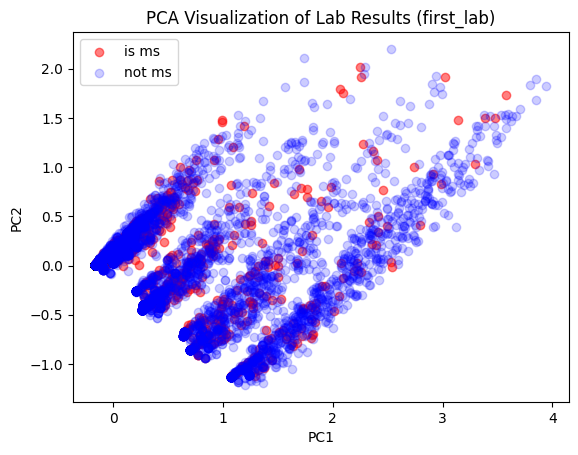


Top 5 features for principal component 1:
OMOP 3000963: 0.43775004816477703
OMOP 3023314: 0.4251660518398674
OMOP 3020416: 0.36914044425697395
OMOP 3034426: 0.2871873469826636
OMOP 3006906: 0.19948713702884027

Top 5 features for principal component 2:
OMOP 3023314: -0.45665348358649643
OMOP 3000963: -0.4090904369563934
OMOP 3034426: 0.32271795055215086
OMOP 3027315: 0.2803493884308245
OMOP 3020416: -0.27319404852931906

Top 5 features for principal component 3:
OMOP 3000905: 0.6766950067003791
OMOP 3013650: 0.4346268072641397
OMOP 3004327: 0.26285616055855787
OMOP 3034426: -0.19132466017042482
OMOP 3027315: -0.17578729271763657


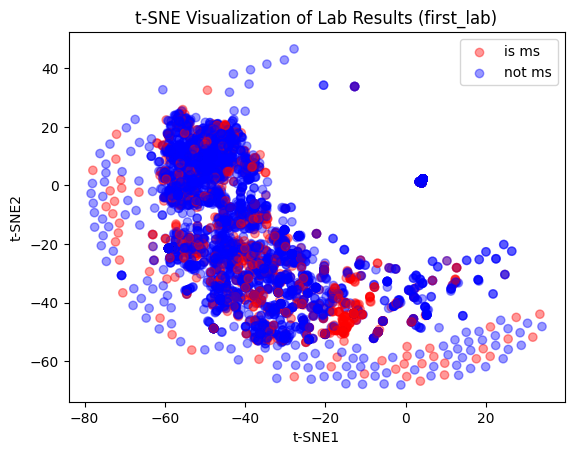



last_lab:



<ipython-input-2-173a6022cea9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = dem[dem['cohort_id'].isin(X.index)]['is_ms']
<ipython-input-2-173a6022cea9>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = X['is_ms'].astype(int)


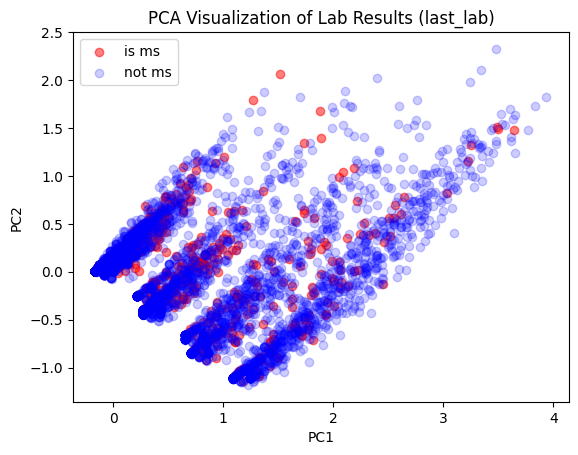


Top 5 features for principal component 1:
OMOP 3000963: 0.43617823144962437
OMOP 3023314: 0.429638338874194
OMOP 3020416: 0.3818042270650091
OMOP 3034426: 0.28509804837477076
OMOP 3006906: 0.1998633369297205

Top 5 features for principal component 2:
OMOP 3023314: -0.4513666156043128
OMOP 3000963: -0.40818924334307605
OMOP 3034426: 0.32761296555964153
OMOP 3027315: 0.2840980387114065
OMOP 3020416: -0.2586110303229861

Top 5 features for principal component 3:
OMOP 3000905: 0.6703811988102459
OMOP 3013650: 0.3708145363928633
OMOP 3004327: 0.2951885491381079
OMOP 3027315: -0.2172927793913431
OMOP 40758903: -0.17406460193027934


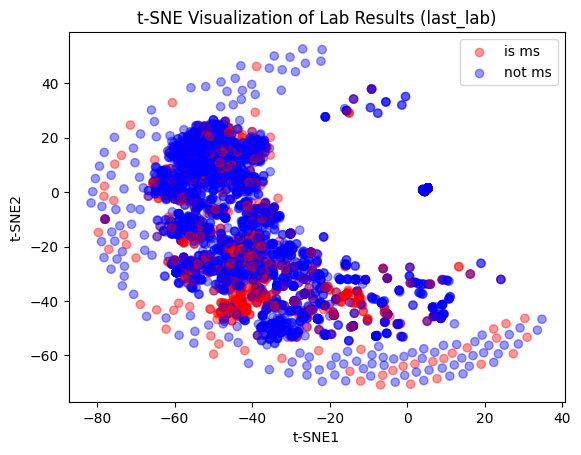



any_abnorm:



<ipython-input-2-173a6022cea9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = dem[dem['cohort_id'].isin(X.index)]['is_ms']
<ipython-input-2-173a6022cea9>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_ms'] = X['is_ms'].astype(int)


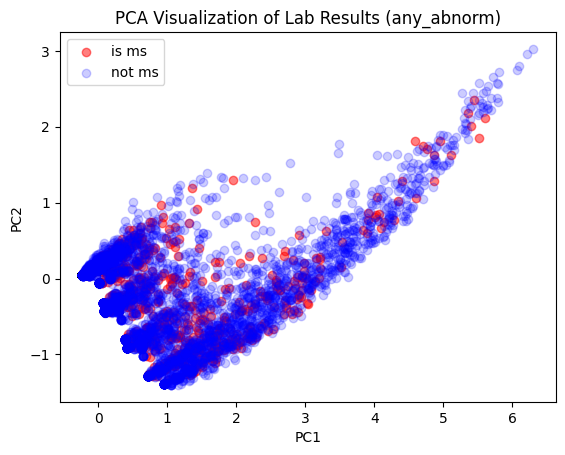


Top 5 features for principal component 1:
OMOP 3023314: 0.3232582308017438
OMOP 3000963: 0.32099102276278496
OMOP 3020416: 0.301065641250499
OMOP 3000905: 0.23582877654459436
OMOP 3019550: 0.2251284877261632

Top 5 features for principal component 2:
OMOP 3023314: -0.4821795650746321
OMOP 3000963: -0.47239769471661125
OMOP 3020416: -0.3685136240516534
OMOP 3027315: 0.14725683467480008
OMOP 3013502: 0.14021842669594425

Top 5 features for principal component 3:
OMOP 3013650: -0.340071503661992
OMOP 3004327: -0.329666273009231
OMOP 3027315: 0.2653970682867799
OMOP 3000905: -0.2595053437340139
OMOP 3028615: -0.22706544363938122


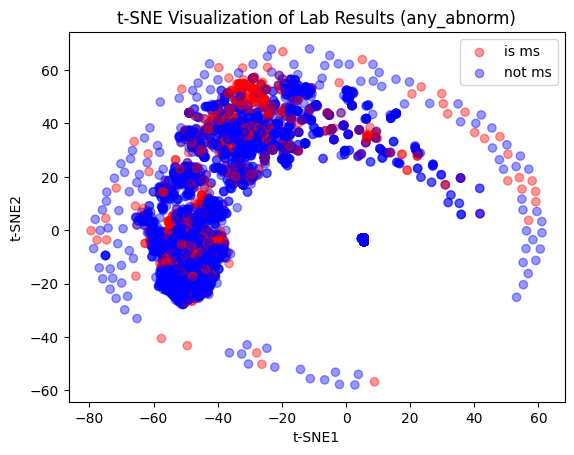

In [ ]:
# PCA+tSNE PART 1
df_ids = ['first_lab', 'last_lab', 'any_abnorm']

top_features = {}
""" Generates binary matrix and performs PCA and tSNE for each patient result selection method"""
for df_id in df_ids:
  top_features[df_id] = {}
  print('\n\n' + df_id + ':\n')
  abnormal_df = pd.read_csv(filepath + 'is_abnorm(' + df_id + ').csv', index_col=0, dtype = int)


  # fill binary matrix with 1s where a patient had an abnormal result for a given lab test
  cohorts = list(set(res['cohort_id']))
  omops = list(set(abnormal_df['OMOPid']))
  X = pd.DataFrame(index = cohorts, columns = omops)
  X = X.fillna(0)
  for cohort in cohorts:
    abnorm_results = list(set(abnormal_df[(abnormal_df['cohort_id'] == cohort) & (abnormal_df['is_abnorm'] == 1)]['OMOPid']))
    for omop in abnorm_results:
      X.loc[cohort, omop] = 1

  # remove cols (labs) with 0 abnormal results
  X = X.loc[:, (X != 0).any(axis=0)]

  # replace 0 with -1 for better visualization
  # X = X.replace(0, -1)

  # add ms labels and convert to integer
  X['is_ms'] = dem[dem['cohort_id'].isin(X.index)]['is_ms']
  X['is_ms'] = X['is_ms'].astype(int)

  # Perform PCA
  pca = PCA(n_components=3)
  data_pca = pca.fit_transform(X.iloc[:, :-1])

  # Plot the results
  fig, ax = plt.subplots()

  ms_scatter = ax.scatter(data_pca[:, 0][X.iloc[:, -1] == 1], data_pca[:, 1][X.iloc[:, -1] == 1], c='red', alpha=0.5, label='is ms')
  not_ms_scatter = ax.scatter(data_pca[:, 0][X.iloc[:, -1] == 0], data_pca[:, 1][X.iloc[:, -1] == 0], c='blue', alpha=0.2, label='not ms')

  plt.title('PCA Visualization of Lab Results (' + df_id + ')')
  plt.xlabel('PC1')
  plt.ylabel('PC2')

  # Combine scatter plots into a single legend
  plt.legend(handles=[ms_scatter, not_ms_scatter])

  plt.show()

  # Take a look at feature loadings
  X.columns = X.columns.astype(str)

  # # Extract the loadings of the principal components
  loadings = pca.components_

  # PCA+tSNE PART 2

  # Print the top n features with the highest loadings for each principal component
  n = 5
  for i, pc in enumerate(loadings):
      # sort features in decreasing order of their absolute loading values
      top_n_features = sorted(enumerate(pc), key=lambda x: abs(x[1]), reverse=True)[:n]

      # convert the column number in top_n_features to its corresponding OMOP number using the cols of X
      top_n_omops = []
      for item in top_n_features:
          omop_id = X.columns[item[0]]
          updated_item = (omop_id, item[1])
          top_n_omops.append(updated_item)

      # add top n features to dictionary
      top_features[df_id][i+1] = top_n_omops

      print(f"\nTop {n} features for principal component {i+1}:")
      for omop, loading in top_n_omops:
          print(f"OMOP {omop}: {loading}")

  # Perform t-SNE
  tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
  data_tsne = tsne.fit_transform(X.iloc[:, :-1])

  # Convert the labels to color codes using the label-to-color mapping
  color_dict = {1: 'red', 0: 'blue'}
  colors = [color_dict[label] for label in X.iloc[:, -1]]

  # Plot the results
  scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=colors, alpha = 0.4)
  plt.title('t-SNE Visualization of Lab Results (' + df_id + ')')
  plt.xlabel('t-SNE1')
  plt.ylabel('t-SNE2')

   # Define the labels for each category
  label_dict = {1: 'is ms', 0: 'not ms'}

  # Create a custom legend
  handles = [plt.scatter([], [], marker='o', alpha = 0.4, color=color_dict[label], label=label_dict[label]) for label in label_dict.keys()]
  plt.legend(handles=handles)

  plt.show()

  # save X (binary data matrix) to directory
  X.to_csv(filepath + 'patient_abnorm_df(' + df_id + ').csv')


# save the dictionary to a file
with open(filepath + "top_features.pickle", "wb") as f:
    pickle.dump(top_features, f)


In [ ]:
from collections import defaultdict
from itertools import islice

# load top features dict
with open(filepath + "top_features.pickle", "rb") as f:
    top_features = pickle.load(f)

# print the loaded dictionary
# print(top_features)

# Get top loadings
top_loadings = {}
for lab in top_features:
  curr_loadings = defaultdict(int)
  pcs = top_features[lab]
  for pc in pcs.items():
    for feature in pc[1]:
      curr_loadings[feature[0]] += abs(feature[1])
  top_loadings[lab] = dict(sorted(curr_loadings.items(), key=lambda x: x[1], reverse=True))


# # do for each of first, last, and any lab
X = pd.read_csv(filepath +'patient_abnorm_df.csv', index_col=False)
X.set_index("Unnamed: 0", inplace=True)
X.index.name = "patient_id"

# Get the index of the first top feature for PC1
feature_omop_ids =  [top_loadings[key] for key in top_loadings]
# feature_idxs = set([item for sublist in feature_idxs for item in sublist])

# Trim top 5 loadings for each of first, last, any. ----> pc_dict
pc_dict = {}
for lab in top_loadings:
  pc_dict[lab] = dict(islice(top_loadings[lab].items(), 5))

In [ ]:
# https://athena.ohdsi.org/search-terms/terms
omop2name = {3023314 : 'Hematocrit of Blood',
             3000963 : "Hemoglobin in Blood",
             3024172 : "Erythropoietin in Serum or Plasma",
             3000905 : "Leukocytes in Blood",
             40758903 : "Hemoglobin in Blood by Oximetry",
             3035583 : "Leukocytes in Urine sediment",
             3017315 : "Amylase in Urine",
             3017264 : "Hydroxyproline in Serum or Plasma",
             40765040 : "25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 in Serum or Plasma",
             3009827 : "Alpha-2-Macroglobulin in Serum or Plasma",
             3020416 : "Erythrocytes in Blood",
             3027315 : "Oxygen in Blood",
             3006923 : "Alanine aminotransferase in Serum or Plasma",
             3023465 : "Gamma globulin in Serum or Plasma",
             3023420 : "DNA double strand Ab in Serum",
             40760947 : "dRVVT W excess phospholipid",
             3006906 : "Calcium in Serum or Plasma",
             3007070 : "Cholesterol in HDL in Serum or Plasma",
             3039783 : "Alpha-1-fetoprotein.tumor marker in Serum or Plasma",
             3044974 : "Prealbumin in Serum or Plasma by Nephelometry",
             3005719 : "IgG in Serum or Plasma",
             3037551 : "Cancer Ag 125 in Serum or Plasma",
             3034426 : "Prothrombin time (PT)",
             3039219 : "CD3-CD56+ cells in Blood",
             3016228 : "CD19 cells/100 cells in Blood",
             3020222 : "IgG clearance/Albumin clearance in Serum and CSF",
             3010503 : "CD19 cells in Blood"}

In [ ]:
pc_dict

{'first_lab': {'3023314': 0.8818195354263638,
  '3000963': 0.8468404851211704,
  '3034426': 0.8012299577052393,
  '3000905': 0.6766950067003791,
  '3020416': 0.6423344927862931},
 'last_lab': {'3023314': 0.8810049544785068,
  '3000963': 0.8443674747927004,
  '3000905': 0.6703811988102459,
  '3020416': 0.6404152573879952,
  '3034426': 0.6127110139344123},
 'any_abnorm': {'3023314': 0.8054377958763759,
  '3000963': 0.7933887174793962,
  '3020416': 0.6695792653021524,
  '3000905': 0.49533412027860824,
  '3027315': 0.41265390296158}}

In [ ]:
# # Plot top features
# # plt.figure(figsize=(10, 6))

# colors = ['blue', 'orange', 'green']

# # for i, key in enumerate(pc_dict.keys()):
# #     plt.bar([omop2name[int(k)] for k in pc_dict[key].keys()], pc_dict[key].values(),
# #             color=colors[i], width=0.4 - 0.1*i)

# # Set up x labels and positions
# x_labels = list(pc_dict['first_lab'].keys())
# x_pos = np.arange(len(x_labels))

# # Create bar plot
# fig, ax = plt.subplots()
# for i, outer_key in enumerate(pc_dict.keys()):
#     y_values = list(pc_dict[outer_key].values())
#     ax.bar(x_pos + i*0.2, y_values, width=0.2, color=colors[i])

# # Set x ticks and labels
# ax.set_xticks(x_pos + 0.2)
# ax.set_xticklabels(x_labels)

# # Add legend
# ax.legend(list(pc_dict.keys()))

# plt.xticks(rotation=90)
# plt.xlabel('Feature (Lab Name)')
# plt.ylabel('PC Loading')
# plt.legend(['First Lab', 'Last Lab', 'Any Abnormal'])
# plt.title('Top 5 Features for each Patient Result Selection Method')
# plt.show()

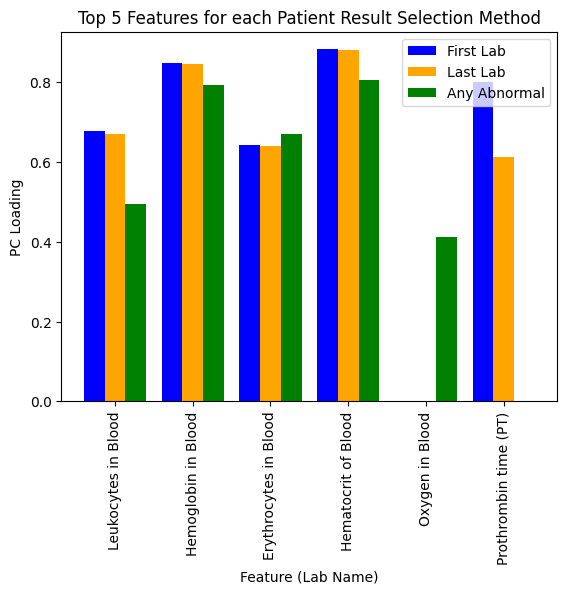

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Define colors for each outer key
colors = ['blue', 'orange', 'green']

# Get unique inner keys
inner_keys = sorted(set(key for subdict in pc_dict.values() for key in subdict))

# Set the width of each bar
bar_width = 0.8 / len(pc_dict)

# Initialize the x position for each inner key
x_positions = np.arange(len(inner_keys))

# Plot the bars for each outer key
for i, (outer_key, subdict) in enumerate(pc_dict.items()):
    y_values = [subdict.get(key, 0) for key in inner_keys]
    plt.bar(x_positions + i * bar_width, y_values, color=colors[i], width=bar_width)

# Set the x ticks and labels
plt.xticks(x_positions + bar_width * (len(pc_dict) - 1) / 2, [omop2name[int(k)] for k in inner_keys], rotation=90)

plt.xlabel('Feature (Lab Name)')
plt.ylabel('PC Loading')
plt.legend(['First Lab', 'Last Lab', 'Any Abnormal'])
plt.title('Top 5 Features for each Patient Result Selection Method')
plt.show()
# import matplotlib.pyplot as plt
# import numpy as np

# # Define colors for each outer key
# colors = ['blue', 'orange', 'green']

# # Get unique inner keys
# inner_keys = sorted(set(key for subdict in pc_dict.values() for key in subdict))

# # Set the width of each bar
# bar_width = 0.8 / len(pc_dict)

# # Initialize the x position for each inner key
# x_positions = np.arange(len(inner_keys))

# # Initialize y values for each outer key and inner key
# y_values = {outer_key: [subdict.get(key, 0) for key in inner_keys] for outer_key, subdict in pc_dict.items()}

# # Plot the bars for each outer key
# for i, outer_key in enumerate(pc_dict.keys()):
#     plt.bar(x_positions + i * bar_width, y_values[outer_key], color=colors[i], width=bar_width)

# # Get the sum of y values for each inner key
# sum_y_values = [sum(y_values[outer_key][idx] for outer_key in pc_dict.keys()) for idx in range(len(inner_keys))]

# # Get the sorted indices of the sum_y_values
# sorted_indices = sorted(range(len(sum_y_values)), key=lambda k: sum_y_values[k], reverse=True)

# # Set the x ticks and labels
# plt.xticks(x_positions + bar_width * (len(pc_dict) - 1) / 2, [omop2name[int(inner_keys[i])] for i in sorted_indices], rotation=90)

# plt.xlabel('Feature (Lab Name)')
# plt.ylabel('PC Loading')
# plt.legend(['First Lab', 'Last Lab', 'Any Abnormal'])
# plt.title('Top 5 Features for each Patient Result Selection Method')
# plt.show()


In [ ]:
top_features = ['40765040', '3020222', '3010503', '3039219', '3016228']

In [ ]:
pc_dict

{'first_lab': {'3023314': 0.8818195354263638,
  '3000963': 0.8468404851211704,
  '3034426': 0.8012299577052393,
  '3000905': 0.6766950067003791,
  '3020416': 0.6423344927862931},
 'last_lab': {'3023314': 0.8810049544785068,
  '3000963': 0.8443674747927004,
  '3000905': 0.6703811988102459,
  '3020416': 0.6404152573879952,
  '3034426': 0.6127110139344123},
 'any_abnorm': {'3023314': 0.8054377958763759,
  '3000963': 0.7933887174793962,
  '3020416': 0.6695792653021524,
  '3000905': 0.49533412027860824,
  '3027315': 0.41265390296158}}

In [ ]:
""" Perform Fisher's exact test to determine which labs are significant to MS. Makes a copy of X and
labels cells as -1 wherever a patient does not take the test. Then ignores these when creating contingency
tables. Repeats this for each variation of X (first, last, any)."""
# option 1 = 2 min. option 2 = 12 min ----> same result (52, 52, 57 significant labs)
import numpy as np
from scipy.stats import fisher_exact
# fishers exact test for labs significant to MS population
df_ids = ['first_lab', 'last_lab', 'any_abnorm']

# do for each of first, last, and any lab
for df_id in df_ids:
  X = pd.read_csv(filepath +'patient_abnorm_df(' + df_id + ').csv', index_col=False)
  X.set_index("Unnamed: 0", inplace=True)
  X.index.name = "patient_id"

  # mark rows as -1 if they have not been taken by a patient
  # create df with -1 where patient did not take the lab
  lab_set_dict = {}
  for index, row in res.iterrows():
    pid = row['cohort_id']
    lid = row['OMOPid']
    if pid in lab_set_dict:
        lab_set_dict[pid].add(lid)
    else:
        lab_set_dict[pid] = {lid}

  # copy X
  sig_X = X.copy()

  for index, row in sig_X.iterrows():
    pid = row.name
    # make it -1
    for col in sig_X.columns[:-1]:
        if int(col) not in lab_set_dict[pid]:
            sig_X.at[pid, col] = -1
  # display(sig_X)

  significant_labs = []  # list to store significant labs

  for column in sig_X.columns[:-1]:
    X_filtered = sig_X[sig_X[column] != -1]
    contingency_table = pd.crosstab(X_filtered[column], X_filtered['is_ms'], dropna=False)

    # # option 1::::: DROP CONTINGENCY TABLES THAT ARE NOT 2x2 (2 min)
    if contingency_table.shape != (2,2):
      continue

    # # option 2::::: ENSURE CONTINGENCY TABLES ARE 2x2 (12 min)
    # Check if contingency_table has 0 and 1 columns, and add them if missing
    # if 0 not in contingency_table.columns:
    #     contingency_table[0] = 0
    # if 1 not in contingency_table.columns:
    #     contingency_table[1] = 0

    # # Check if contingency_table has 0 and 1 rows, and add them if missing
    # if 0 not in contingency_table.index:
    #     contingency_table.loc[0] = [0] * contingency_table.shape[1]
    # if 1 not in contingency_table.index:
    #     contingency_table.loc[1] = [0] * contingency_table.shape[1]

    # Sort the columns and rows to ensure consistent order
    contingency_table = contingency_table.sort_index(axis=1).sort_index(axis=0)

    oddsratio, pvalue = fisher_exact(contingency_table)
    if pvalue < 0.05:
      significant_labs.append(column)
        # print(f"For lab {column}, p-value = {pvalue}")

  print(df_id)
  # for lab in significant_labs:
  # print(significant_labs)
  print('Number of labs significant to MS group: ', len(significant_labs))
  print(type(significant_labs[0]))
  # sig_labs_top_loadings = set()
  print("Top 5 Model features in siginificant_labs?\t\t ", [feature in significant_labs for feature in top_features])

  # print labs that are both in top 5 features and significant to MS population.
  print("Labs in top 5 features AND significant to MS:")
  for omop in pc_dict[df_id]:
    if omop in significant_labs:
      curr = omop2name[int(omop)]
      # sig_labs_top_loadings.add(curr)
      print('\t', curr)

  print('\n')
  #

first_lab
Number of labs significant to MS group:  52
<class 'str'>
Top 5 Model features in siginificant_labs?		  [True, True, False, False, False]
Labs in top 5 features AND significant to MS:
	 Hematocrit of Blood
	 Hemoglobin in Blood
	 Leukocytes in Blood
	 Erythrocytes in Blood


last_lab
Number of labs significant to MS group:  52
<class 'str'>
Top 5 Model features in siginificant_labs?		  [True, True, False, False, True]
Labs in top 5 features AND significant to MS:
	 Hematocrit of Blood
	 Hemoglobin in Blood
	 Leukocytes in Blood
	 Erythrocytes in Blood


any_abnorm
Number of labs significant to MS group:  57
<class 'str'>
Top 5 Model features in siginificant_labs?		  [True, True, False, False, False]
Labs in top 5 features AND significant to MS:
	 Hematocrit of Blood
	 Hemoglobin in Blood
	 Erythrocytes in Blood
	 Leukocytes in Blood




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

df_ids = ['first_lab', 'last_lab', 'any_abnorm']

In [ ]:
#33 min (just load the models and do the visualizations separately)

# do for each of first, last, and any lab
for df_id in df_ids:
  print('training on data from ' + df_id + '...')
  X = pd.read_csv(filepath +'patient_abnorm_df(' + df_id + ').csv', index_col=False)
  X.set_index("Unnamed: 0", inplace=True)
  X.index.name = "patient_id"

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X.drop(['is_ms'], axis=1), X['is_ms'], test_size=0.2, random_state=42)

  # Save X_train/test, Y_train/test to inspect top features and score later on
  X_train.to_csv(filepath + 'x_train_' + df_id + '.csv')
  X_test.to_csv(filepath + 'x_test_' + df_id + '.csv')
  y_train.to_csv(filepath + 'y_train_' + df_id + '.csv')
  y_test.to_csv(filepath + 'y_test_' + df_id + '.csv')

  # find best parameters with grid search
  param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2']
  }

  print('Performing grid search...')

  # Create a random forest classifier
  rf = RandomForestClassifier(random_state=42)

  # Create a grid search object with cross-validation
  grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

  # Fit the grid search to the data
  grid_search.fit(X_train, y_train)


  max_depth = grid_search.best_params_['max_depth']
  max_features = grid_search.best_params_['max_features']
  n_estimators = grid_search.best_params_['n_estimators']

  print('training random forest model on best hyperparameters...')

  # Train a random forest model
  rf_model = RandomForestClassifier(n_estimators = n_estimators, random_state=42, max_depth = max_depth, max_features = max_features)
  rf_model.fit(X_train, y_train)

  # Save the trained model to a file
  print('saving model (' + df_id + ')...')
  dump(rf_model, filepath + 'ms_model_' + df_id + '.joblib')
  print('model saved!')

  # Evaluate the model
  print("Training accuracy:", rf_model.score(X_train, y_train))
  print("Testing accuracy:", rf_model.score(X_test, y_test))
  print('\n\n')


  # VISUALIZATIONS
  # print("\n\nVISUALIZATIONS:\n")
  # # Feature Importance Plot
  # feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
  # feature_importance.sort_values('Importance', inplace=True, ascending=False)
  # plt.figure(figsize=(10, 6))
  # sns.barplot(x='Importance', y='Feature', data=feature_importance)
  # plt.title('Feature Importance ' + df_id)
  # plt.show()

  # # Confusion Matrix
  # y_pred = rf_model.predict(X_test)
  # cm = confusion_matrix(y_test, y_pred)
  # sns.heatmap(cm, annot=True, cmap='Blues')
  # plt.xlabel('Predicted label')
  # plt.ylabel('True label')
  # plt.title('Confusion Matrix ' + df_id)
  # plt.show()

  # # ROC Curve
  # y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
  # fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  # auc_score = roc_auc_score(y_test, y_pred_prob)
  # plt.figure(figsize=(8, 6))
  # plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc_score))
  # plt.plot([0, 1], [0, 1], 'k--')
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('ROC Curve ' + df_id)
  # plt.legend()
  # plt.show()

first_lab
*Model Accuracy*
Training accuracy: 0.843167484232656
Testing accuracy: 0.8344544095665172


Top 5 Features:
1. 25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 in Serum or Plasma (0.09894978524966691)
2. CD3-CD56+ cells in Blood (0.05097595037417543)
3. CD19 cells/100 cells in Blood (0.034872945939374)
4. IgG clearance/Albumin clearance in Serum and CSF (0.03397732850016991)
5. CD19 cells in Blood (0.03129269570740219)


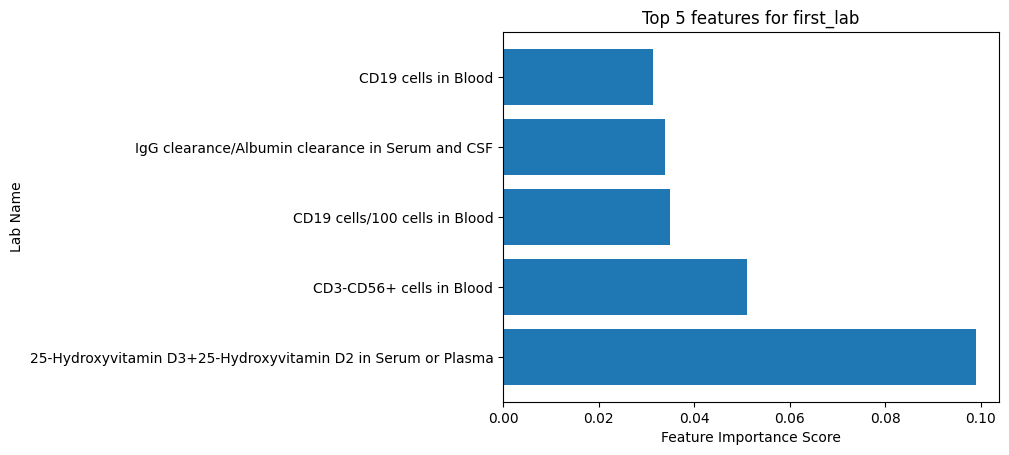





last_lab
*Model Accuracy*
Training accuracy: 0.8434945106283579
Testing accuracy: 0.8335201793721974


Top 5 Features:
1. 25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 in Serum or Plasma (0.10285292140381662)
2. CD3-CD56+ cells in Blood (0.0519733940152311)
3. CD19 cells/100 cells in Blood (0.04508728988681077)
4. IgG clearance/Albumin clearance in Serum and CSF (0.03449924839409715)
5. CD19 cells in Blood (0.028744708064948922)


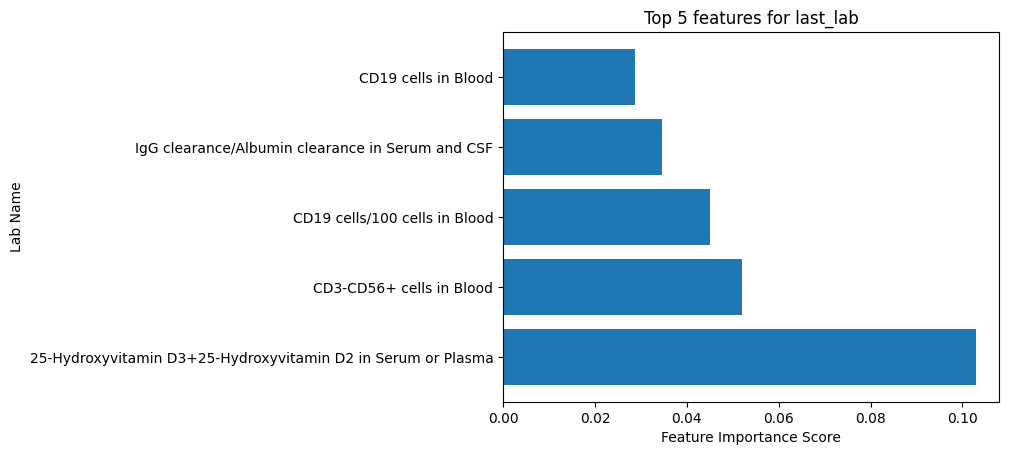





any_abnorm
*Model Accuracy*
Training accuracy: 0.8466246204157907
Testing accuracy: 0.8361360239162929


Top 5 Features:
1. 25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 in Serum or Plasma (0.10178369116664787)
2. CD3-CD56+ cells in Blood (0.04314175273896483)
3. CD19 cells/100 cells in Blood (0.038240516030997186)
4. IgG clearance/Albumin clearance in Serum and CSF (0.026659888445638005)
5. CD19 cells in Blood (0.025707643905126365)


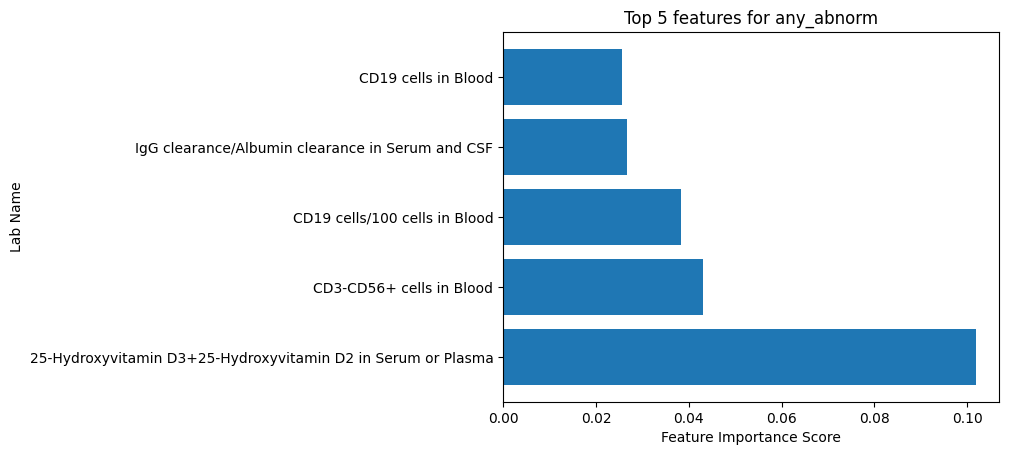

In [ ]:
# from google.colab import drive
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# drive.mount('/content/drive')
# filepath = "/content/drive/MyDrive/Spoke/"

top_features_omop = set()
for df_id in df_ids:
  print(df_id)

  # load the trained model
  rf_model = load(filepath + 'ms_model_' + df_id + '.joblib')

  # load X_train/test Y_train/test
  X_train = pd.read_csv(filepath + 'x_train_' + df_id + '.csv')
  X_train.set_index("patient_id", inplace=True)
  X_test = pd.read_csv(filepath + 'x_test_' + df_id + '.csv')
  X_test.set_index("patient_id", inplace=True)
  y_train = pd.read_csv(filepath + 'y_train_' + df_id + '.csv')
  y_train.set_index("patient_id", inplace=True)
  y_test = pd.read_csv(filepath + 'y_test_' + df_id + '.csv')
  y_test.set_index("patient_id", inplace=True)

  # Get the feature names
  # feature_names = X_train.columns.tolist()[1:]
  feature_names = X_train.columns.tolist()

  # Get feature importances and sort them in descending order
  importances = rf_model.feature_importances_
  indices = np.argsort(importances)[::-1]

  # Evaluate the model
  print("*Model Accuracy*\nTraining accuracy:", rf_model.score(X_train, y_train))
  print("Testing accuracy:", rf_model.score(X_test, y_test))
  print('\n')

  # Print the top 5 features and their importance scores
  print("Top 5 Features:")
  for f in range(5):
      print(f"{f + 1}. {omop2name[int(feature_names[indices[f]])]} ({importances[indices[f]]})")
      top_features_omop.add(feature_names[indices[f]])
  # continue
  # Create a horizontal bar chart
  plt.barh(range(5), importances[indices[:5]], align='center')
  plt.yticks(range(5), [omop2name[int(feature_names[i])] for i in indices[:5]])
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Lab Name')
  plt.title(f'Top 5 features for {df_id}')

  plt.show()
  print('\n\n\n')

In [ ]:
list(top_features_omop)

['3020222', '40765040', '3039219', '3010503', '3016228']

In [ ]:
top_labs = [omop2name[int(omop)] for omop in top_features]
top_labs

['25-Hydroxyvitamin D3+25-Hydroxyvitamin D2 in Serum or Plasma',
 'IgG clearance/Albumin clearance in Serum and CSF',
 'CD19 cells in Blood',
 'CD3-CD56+ cells in Blood',
 'CD19 cells/100 cells in Blood']